In [108]:
from src.data_gen import data_gen, data_gen_xu
from src.gsc_ipca import gsc_ipca
from src.gsc_ife import gsc_ife
from src.gsc_ipca_new import gsc_ipca_new
from src.scm import scm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
color

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [144]:
# number of time periods and individuals
T0, T1 = 20, 10
N_co, N_tr = 45, 5

# number of covariates and time-varying factors
L, K = 5, 2
# drift and ratio of observing covariates
drift, w = 2, 0.3

In [145]:
# Initialize the dictionary
#bias_dict1 = {'bias_ipca': [], 'bias_ife': [], 'bias_ipca_new': [], 'bias_scm': []}
bias_dict1 = {'bias_ipca': [], 'bias_ife': [], 'bias_scm': []}

for i in range(100):
    # Generate data (assuming data_gen is a defined function)
    df = data_gen(T0=T0, T1=T1, N_co=N_co, N_tr=N_tr, L=L, K=K, drift=drift)
    df['const'] = 1

    # True ATT calculation
    ATT = df.query("tr_group==1").groupby('year')['eff'].mean()[-T1:].mean()

    # Define covariates and observed covariates
    covariates = ['x' + str(i) for i in range(1, L+1)]
    L_obs = round(w * len(covariates))
    obs_covariates = list(np.random.choice(covariates, size=L_obs, replace=False))+ ['const']

    # Fit the GSC-IPCA model and calculate bias
    gsc_ipca_model = gsc_ipca(df=df, id='id', year='year', outcome='y', covariates=obs_covariates, treated='treated', K=K, L=L_obs+1)
    gsc_ipca_model.fit(verbose=False)
    att_ipca = (df.query("tr_group==1").groupby('year')['y'].mean()[-T1:] - gsc_ipca_model.Y_syn.mean(axis=0)[-T1:]).mean()
    bias_dict1['bias_ipca'].append(att_ipca - ATT)

    # Fit the GSC-IFE model and calculate bias
    gsc_ife_model = gsc_ife(df=df, id='id', year='year', outcome='y', covariates=obs_covariates, treated='treated', K=K)
    gsc_ife_model.fit(verbose=False)
    att_ife = (df.query("tr_group==1").groupby('year')['y'].mean()[-T1:] - gsc_ife_model.Y_syn.mean(axis=1)[-T1:]).mean()
    bias_dict1['bias_ife'].append(att_ife - ATT)

    # Fit the GSC-IPCA-new model and calculate bias
    #gsc_ipca_new_model = gsc_ipca_new(df=df, id='id', time='year', outcome='y', covariates=obs_covariates, treated='treated', K=K)
    #gsc_ipca_new_model.fit(verbose=False)
    #att_ipca_new = (df.query("tr_group==1").groupby('year')['y'].mean()[-T1:] - gsc_ipca_new_model.Y_syn.mean(axis=0)[-T1:]).mean()
    #bias_dict1['bias_ipca_new'].append(att_ipca_new - ATT)

    # Fit the SCM model and calculate bias
    scm_model = scm(df=df, id='id', year='year', outcome='y', treated='treated', v=None)
    scm_model.fit()
    att_scm = (df.query("tr_group==1").groupby('year')['y'].mean()[-T1:] - scm_model.Y_syn[-T1:]).mean()
    bias_dict1['bias_scm'].append(att_scm - ATT)

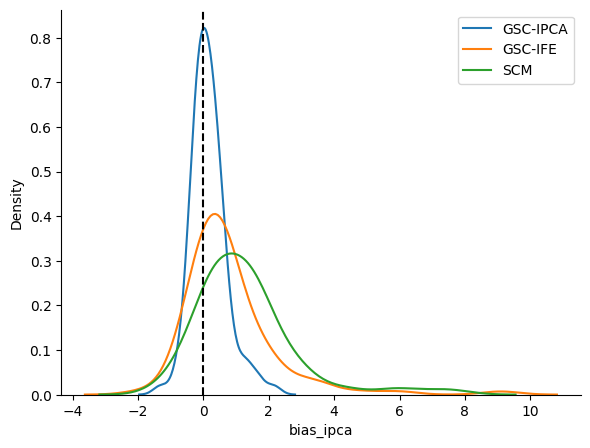

In [146]:
# Convert the dictionary to a pandas DataFrame for analysis or visualization
bias_df1 = pd.DataFrame(bias_dict1)

# plot
plt.figure(figsize=(6.7, 5))
sns.kdeplot(bias_df1['bias_ipca'], label='GSC-IPCA')
sns.kdeplot(bias_df1['bias_ife'], label='GSC-IFE')
#sns.kdeplot(bias_df1['bias_ipca_new'], label='GSC-IPCA-new')
sns.kdeplot(bias_df1['bias_scm'], label='SCM')

plt.axvline(0, color='black', linestyle='--')
plt.legend()
sns.despine()

In [136]:
# set random seed
#np.random.seed(3)
# generate data
T0, T1 = 20, 10
N_co, N_tr = 45, 5
L, K = 2, 1

In [138]:
# Initialize the dictionary
#bias_dict2 = {'bias_ipca': [], 'bias_ife': [], 'bias_ipca_new': [], 'bias_scm': []}
bias_dict2 = {'bias_ipca': [], 'bias_ife': [], 'bias_scm': []}

for i in range(100):
    # Generate data (assuming data_gen is a defined function)
    df = data_gen_xu(T0=T0, T1=T1, N_co=N_co, N_tr=N_tr, w=0.8)
    df['const'] = 1

    # True ATT calculation
    ATT = df.query("tr_group==1").groupby('year')['eff'].mean()[-T1:].mean()

    # Define covariates and observed covariates
    covariates = ['x1', 'x2']
    L_obs = len(covariates)
    obs_covariates = covariates + ['const']

    # Fit the GSC-IPCA model and calculate bias
    gsc_ipca_model = gsc_ipca(df=df, id='id', year='year', outcome='y', covariates=obs_covariates, treated='treated', K=K, L=L_obs+1)
    gsc_ipca_model.fit(verbose=False)
    att_ipca = (df.query("tr_group==1").groupby('year')['y'].mean()[-T1:] - gsc_ipca_model.Y_syn.mean(axis=0)[-T1:]).mean()
    bias_dict2['bias_ipca'].append(att_ipca - ATT)

    # Fit the GSC-IFE model and calculate bias
    gsc_ife_model = gsc_ife(df=df, id='id', year='year', outcome='y', covariates=covariates, treated='treated', K=K)
    gsc_ife_model.fit(verbose=False)
    att_ife = (df.query("tr_group==1").groupby('year')['y'].mean()[-T1:] - gsc_ife_model.Y_syn.mean(axis=1)[-T1:]).mean()
    bias_dict2['bias_ife'].append(att_ife - ATT)

    # Fit the GSC-IPCA-new model and calculate bias
    #gsc_ipca_new_model = gsc_ipca_new(df=df, id='id', time='year', outcome='y', covariates=obs_covariates, #treated='treated', K=K)
    #gsc_ipca_new_model.fit(verbose=False)
    #att_ipca_new = (df.query("tr_group==1").groupby('year')['y'].mean()[-T1:] - gsc_ipca_new_model.Y_syn.mean(axis=0)[-T1:]).mean()
    #bias_dict2['bias_ipca_new'].append(att_ipca_new - ATT)

    # Fit the SCM model and calculate bias
    scm_model = scm(df=df, id='id', year='year', outcome='y', treated='treated', v=None)
    scm_model.fit()
    att_scm = (df.query("tr_group==1").groupby('year')['y'].mean()[-T1:] - scm_model.Y_syn[-T1:]).mean()
    bias_dict2['bias_scm'].append(att_scm - ATT)

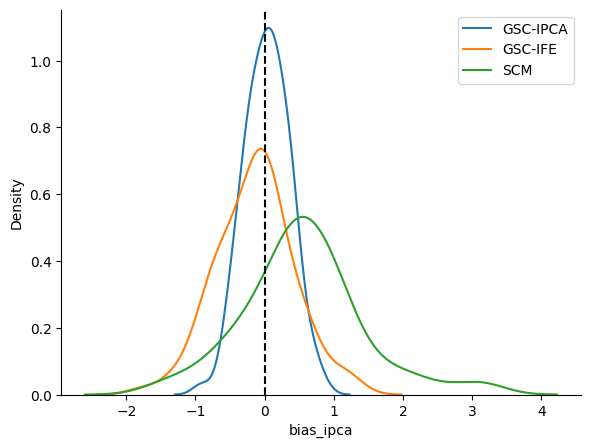

In [140]:
# Convert the dictionary to a pandas DataFrame for analysis or visualization
bias_df2 = pd.DataFrame(bias_dict2)

# plot
plt.figure(figsize=(6.7, 5))
sns.kdeplot(bias_df2['bias_ipca'], label='GSC-IPCA')
sns.kdeplot(bias_df2['bias_ife'], label='GSC-IFE')
#sns.kdeplot(bias_df2['bias_ipca_new'], label='GSC-IPCA-new')
sns.kdeplot(bias_df2['bias_scm'], label='SCM')

plt.axvline(0, color='black', linestyle='--')
plt.legend()
sns.despine()